# Forecasting inflation rate of Peru

**Author**: Valerie Dube

**Date**  : May, 2024

In [135]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler

### 1. Data extraction and database construction

#### 1.1. Transformation 1: Complete inflation expectations missings

In [136]:
inflacion_exp = pd.read_excel(r"./data/inflation_expectations.xlsx")

# Impute the missing values using the spline technique
inflacion_exp['inflacion_exp_spline'] = inflacion_exp['inflacion_exp'].interpolate(option='spline')

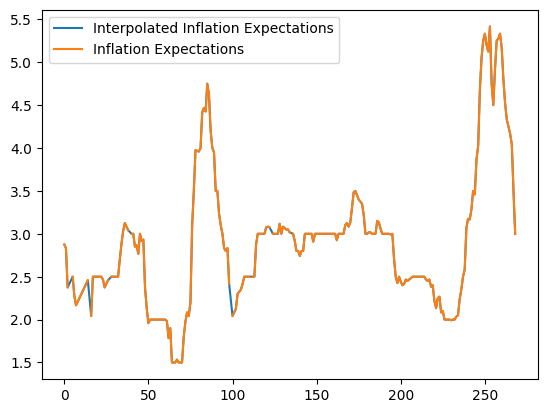

In [137]:
plt.plot(inflacion_exp.index, inflacion_exp['inflacion_exp_spline'], label='Interpolated Inflation Expectations')
plt.plot(inflacion_exp.index, inflacion_exp['inflacion_exp'], label='Inflation Expectations')

plt.legend()
plt.show()

In [138]:
# Save transformed data to Excel file
inflacion_exp['inflacion_exp_spline'].to_excel("./data/inflation_expectations_trans.xlsx")

#### 1.2. Transformation 2: Upsampling private consumption, from quarterly to monthly frequency

In [139]:
consumo = pd.read_excel(r"./data/private_consumption_Q.xlsx")

# Convert 'Date' column to datetime object and set as index
consumo['Date'] = pd.to_datetime(consumo['Date'])
consumo = consumo.set_index('Date')

# Resample to monthly frequency, using the mean to aggregate and interpolate missing values
consumo_resamp = consumo.resample('M').mean().interpolate('linear')

# Export to Excel file
consumo_resamp.to_excel("./data/private_consumption_M.xlsx")

/var/folders/km/jc_93cpj0cv1jgmdmzcmqj6m0000gn/T/ipykernel_2540/1224347561.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  consumo_resamp = consumo.resample('M').mean().interpolate('linear')


#### 1.3. Transformation 3: Upsampling potential GDP, from yearly to monthly frequency, and upsampling quarterly GDP to monthly

In [140]:
pbi_potencial = pd.read_excel(r"./data/pbi_potencial_Y.xlsx")

# Convert 'Date' column to datetime object and set as index
pbi_potencial['Date'] = pd.to_datetime(pbi_potencial['Date'])
pbi_potencial = pbi_potencial.set_index('Date')

# Resample to monthly frequency, using the mean to aggregate and interpolate missing values
pbi_resamp = pbi_potencial.resample('M').mean().interpolate('linear')

# Export to Excel file
pbi_resamp.to_excel("./data/pbi_potencial_M.xlsx")

/var/folders/km/jc_93cpj0cv1jgmdmzcmqj6m0000gn/T/ipykernel_2540/128050504.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pbi_resamp = pbi_potencial.resample('M').mean().interpolate('linear')


In [141]:
pbi = pd.read_excel(r"./data/pbi_Q.xlsx")

# Convert 'Date' column to datetime object and set as index
pbi['Date'] = pd.to_datetime(pbi['Date'])
pbi = pbi.set_index('Date')

# Resample to monthly frequency, using the mean to aggregate and interpolate missing values
pbi_resamp = pbi.resample('M').mean().interpolate('linear')

# Export to Excel file
pbi_resamp.to_excel("./data/pbi_M.xlsx")

/var/folders/km/jc_93cpj0cv1jgmdmzcmqj6m0000gn/T/ipykernel_2540/3973234805.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pbi_resamp = pbi.resample('M').mean().interpolate('linear')


#### 1.4. Transformation 4: Seasonally adjusted M1, M2

In [142]:
raw_df = pd.read_excel(r"./data/raw_database.xlsx", sheet_name=0)

In [143]:
# Convert index to datetime
raw_df['fecha'] = pd.to_datetime(raw_df['fecha'])
raw_df = raw_df.set_index('fecha')

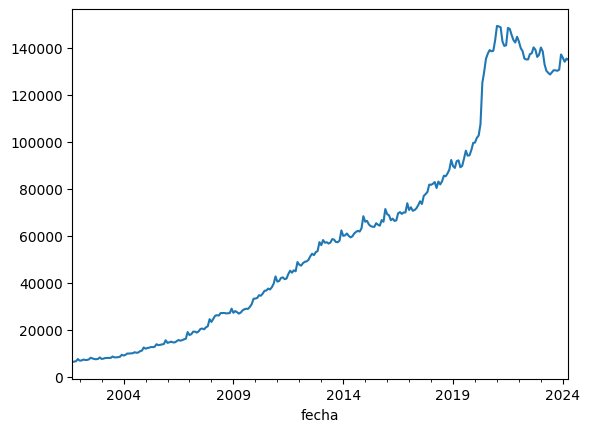

In [144]:
raw_df['m1'].plot()
plt.show()

In [145]:
result = seasonal_decompose(raw_df['m1'], model='multiplicative')

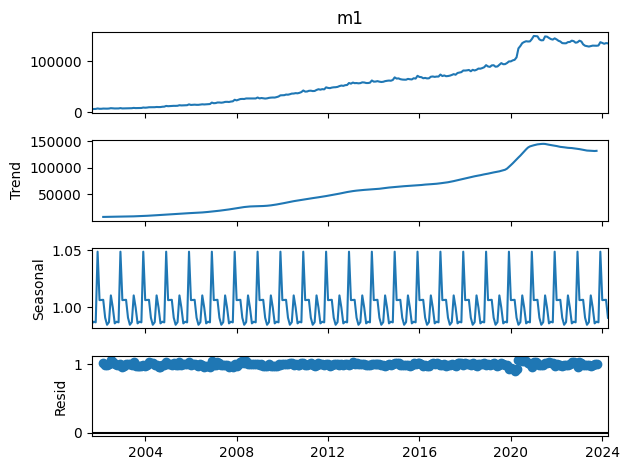

In [146]:
result.plot()
plt.show()

In [147]:
raw_df['m1'] = raw_df['m1'] / result.seasonal

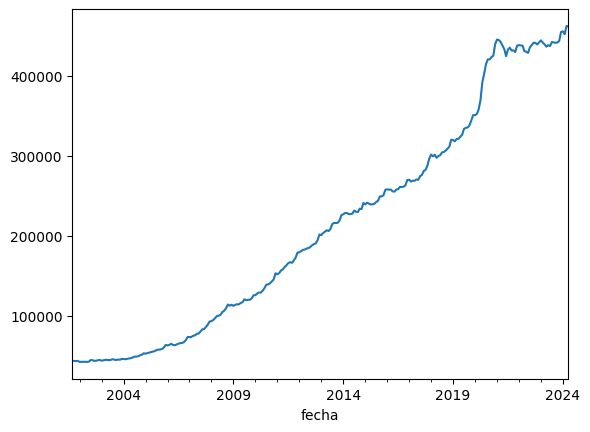

In [148]:
raw_df['m2'].plot()
plt.show()

In [149]:
result = seasonal_decompose(raw_df['m2'], model='multiplicative')

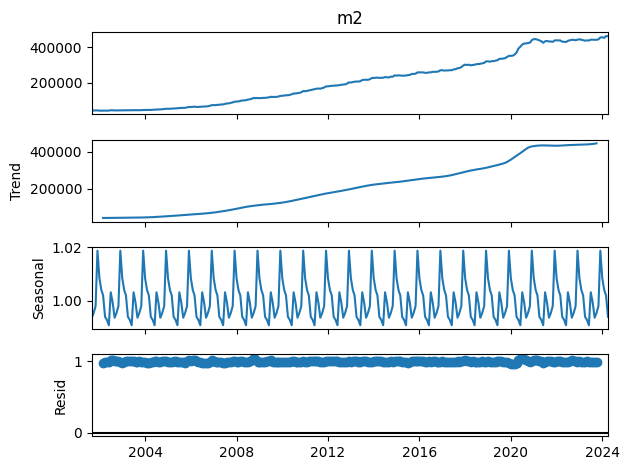

In [150]:
result.plot()
plt.show()

In [151]:
raw_df['m2'] = raw_df['m2'] / result.seasonal

#### 1.5.A. (Database without index) Transformation 5: Remove non-stationarity

In [152]:
raw_df_noindex = raw_df.drop('indice_sent', axis=1) # we eliminate sentiment index and its lag

raw_df_noindex.dropna(inplace=True)

In [153]:
columns_with_high_p_values = []

for column in raw_df_noindex.columns[1:]:
    test_results = adfuller(raw_df_noindex[column])
    
    if test_results[1] > 0.05:
        columns_with_high_p_values.append(column)
        raw_df_noindex[column] = raw_df_noindex[column].diff(periods=1)

raw_df_noindex.dropna(inplace=True)

In [154]:
columns_with_high_p_values

['rem_min',
 'pm',
 'pm_np',
 'pea_ocu',
 'pea_ocu_pe',
 'pea_ocu_me',
 'pea_ocu_ge',
 'pea_adecuada',
 'consumo_priv',
 'm1',
 'm2',
 'base_monetaria',
 'reservas',
 'encaje',
 'tc_us',
 'tc_yen',
 'IPC_sin_alim',
 'IPC_sin_alim_ener',
 'IPC_alim_ener',
 'IPC_imp',
 'IPC_subyacente',
 'IPC_transables']

In [155]:
columns_with_high_p_values = []

for column in raw_df_noindex.columns[1:]:
    test_results = adfuller(raw_df_noindex[column])
    
    if test_results[1] > 0.05:
        columns_with_high_p_values.append(column)
        raw_df_noindex[column] = raw_df_noindex[column].diff(periods=1)
        
raw_df_noindex.dropna(inplace=True)

In [156]:
columns_with_high_p_values

['base_monetaria', 'IPC_sin_alim', 'IPC_transables']

In [157]:
columns_with_high_p_values = []

for column in raw_df_noindex.columns[1:]:
    test_results = adfuller(raw_df_noindex[column])
    
    if test_results[1] > 0.05:
        columns_with_high_p_values.append(column)

In [158]:
columns_with_high_p_values

[]

#### 1.6.A. Add lags

In [159]:
# Number of lags
n_column = raw_df_noindex.shape[1]
n_lags = 1

# Create lagged columns
for col in raw_df_noindex.columns:
    raw_df_noindex[f'{col}_lag'] = raw_df_noindex[col].shift(n_lags)

In [160]:
# Num of features (without lags)
n_features = n_column - 1

In [161]:
# Selection of inflation and lags
df_noindex = raw_df_noindex.iloc[n_lags:, [0] + list(range(n_features + 1, len(raw_df_noindex.columns)))].copy() 

In [162]:
# Save transformed data to Excel file
df_noindex.to_excel("./data/database_noindex.xlsx")

#### 1.5.B. (Database with index) Transformation 5: Remove non-stationarity

In [163]:
raw_df.dropna(inplace=True)

In [164]:
columns_with_high_p_values = []

for column in raw_df.columns[1:]:
    test_results = adfuller(raw_df[column])
    
    if test_results[1] > 0.05:
        columns_with_high_p_values.append(column)
        raw_df[column] = raw_df[column].diff(periods=1)

raw_df.dropna(inplace=True)

In [165]:
columns_with_high_p_values

['rem_min',
 'pm',
 'pm_np',
 'pea_ocu',
 'pea_ocu_pe',
 'pea_ocu_me',
 'pea_ocu_ge',
 'pea_adecuada',
 'desempleo',
 'consumo_priv',
 'm1',
 'm2',
 'base_monetaria',
 'reservas',
 'encaje',
 'tc_us',
 'tc_yen',
 'IPC_sin_alim',
 'IPC_sin_alim_ener',
 'IPC_alim_ener',
 'IPC_imp',
 'IPC_subyacente',
 'IPC_transables']

In [166]:
columns_with_high_p_values = []

for column in raw_df.columns[1:]:
    test_results = adfuller(raw_df[column])
    
    if test_results[1] > 0.05:
        columns_with_high_p_values.append(column)
        raw_df[column] = raw_df[column].diff(periods=1)
        
raw_df.dropna(inplace=True)

In [167]:
columns_with_high_p_values

['base_monetaria',
 'IPC_sin_alim',
 'IPC_alim_ener',
 'IPC_transables',
 'inflacion_exp']

In [168]:
columns_with_high_p_values = []

for column in raw_df.columns[1:]:
    test_results = adfuller(raw_df[column])
    
    if test_results[1] > 0.05:
        columns_with_high_p_values.append(column)

In [169]:
columns_with_high_p_values

[]

In [170]:
# Create lagged columns
for col in raw_df.columns:
    raw_df[f'{col}_lag'] = raw_df[col].shift(n_lags)

In [171]:
# Num of features (without lags)
n_features = n_column - 1

In [172]:
# Selection of inflation, sentiment index and lags
df = raw_df.iloc[n_lags:, [0] + [29] + list(range(n_features + 1, len(raw_df.columns)))].copy() 

In [173]:
# Save transformed data to Excel file
df.to_excel("./data/database_index.xlsx")

### 2. Exploratory analysis

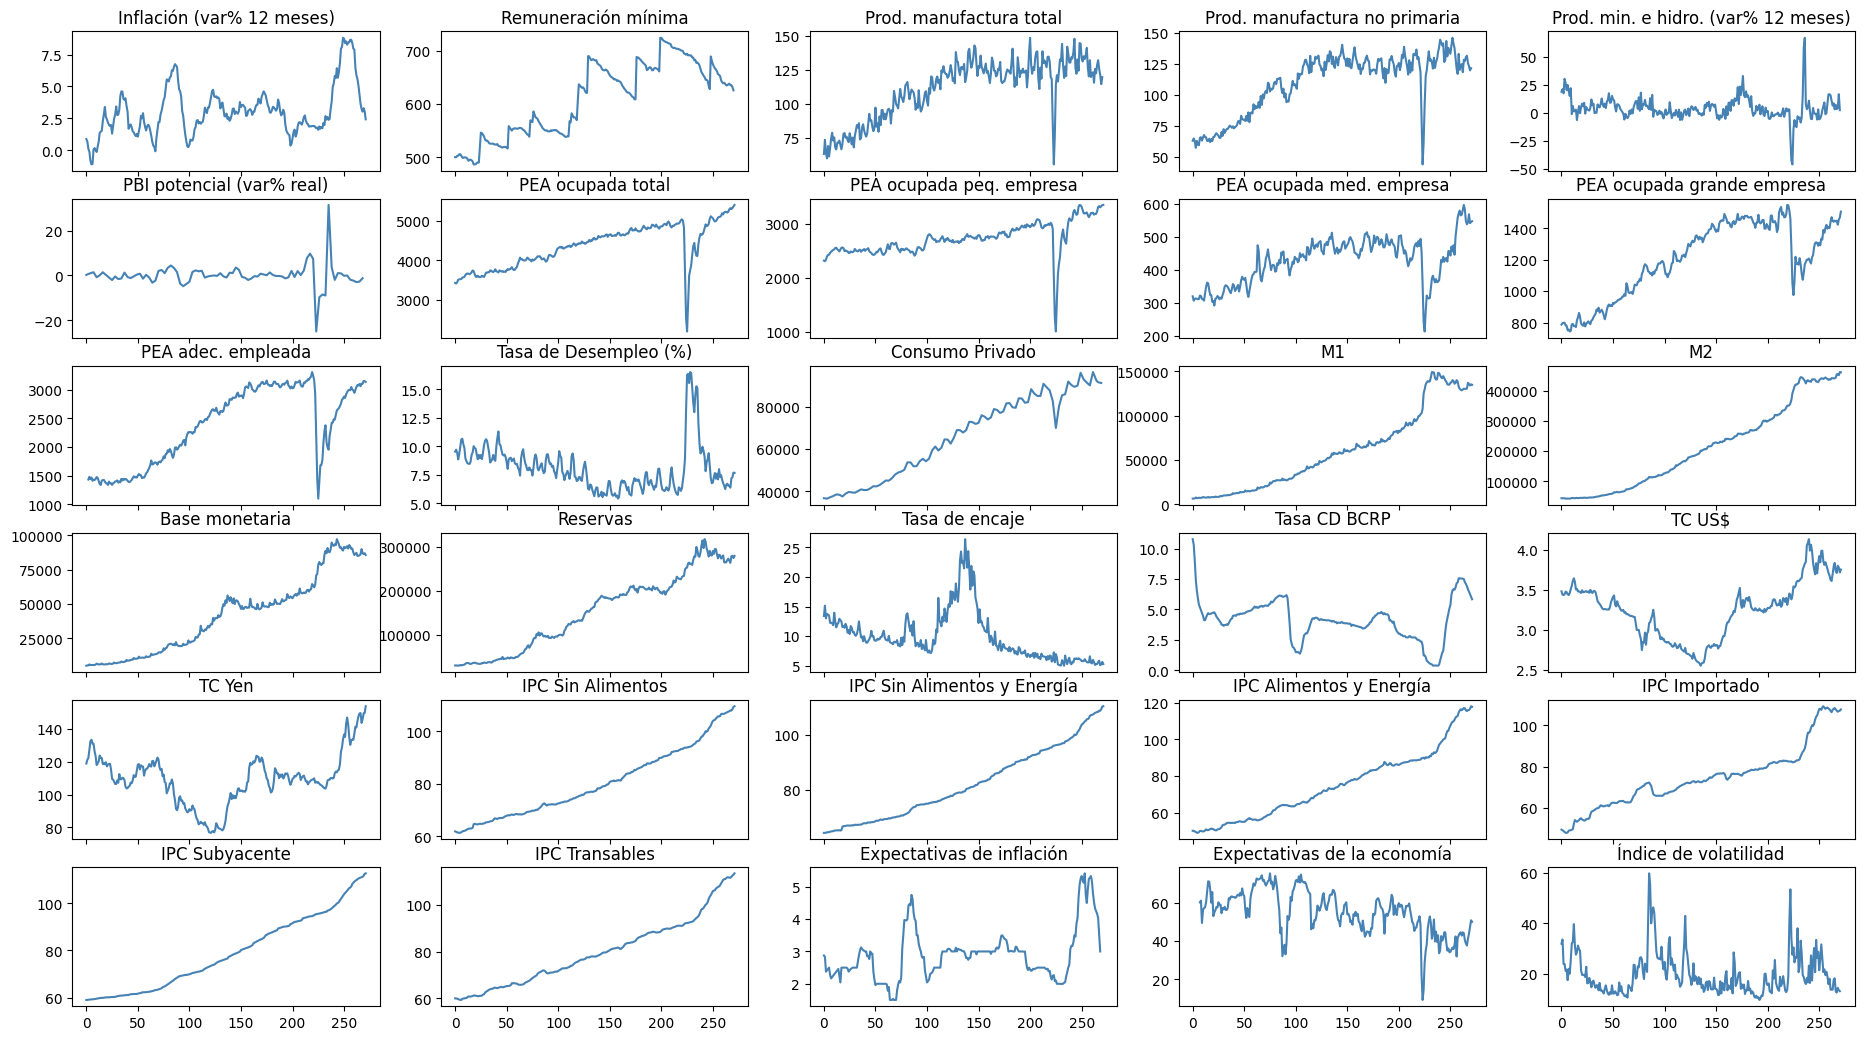

In [174]:
# Read Excel file
before_df = pd.read_excel(r"./data/raw_database.xlsx", sheet_name=0)
before_df = before_df.drop('indice_sent', axis=1)

# Graph of parameters
before_df.iloc[:, 1:].plot(kind ='line',
            subplots = True,
            figsize = (23,17),
            title = ['Inflación (var% 12 meses)', 'Remuneración mínima', 'Prod. manufactura total', 'Prod. manufactura no primaria', 'Prod. min. e hidro. (var% 12 meses)',
                     'PBI potencial (var% real)', 'PEA ocupada total', 'PEA ocupada peq. empresa', 'PEA ocupada med. empresa', 'PEA ocupada grande empresa', 
                     'PEA adec. empleada', 'Tasa de Desempleo (%)', 'Consumo Privado', 'M1', 'M2', 
                     'Base monetaria', 'Reservas', 'Tasa de encaje', 'Tasa CD BCRP', 'TC US$', 
                     'TC Yen', 'IPC Sin Alimentos', 'IPC Sin Alimentos y Energía', 'IPC Alimentos y Energía', 'IPC Importado', 
                     'IPC Subyacente', 'IPC Transables', 'Expectativas de inflación', 'Expectativas de la economía', 'Índice de volatilidad'],
            legend = False,
            layout = (8,5),
            sharex = True,
            color = 'steelblue')
plt.show()

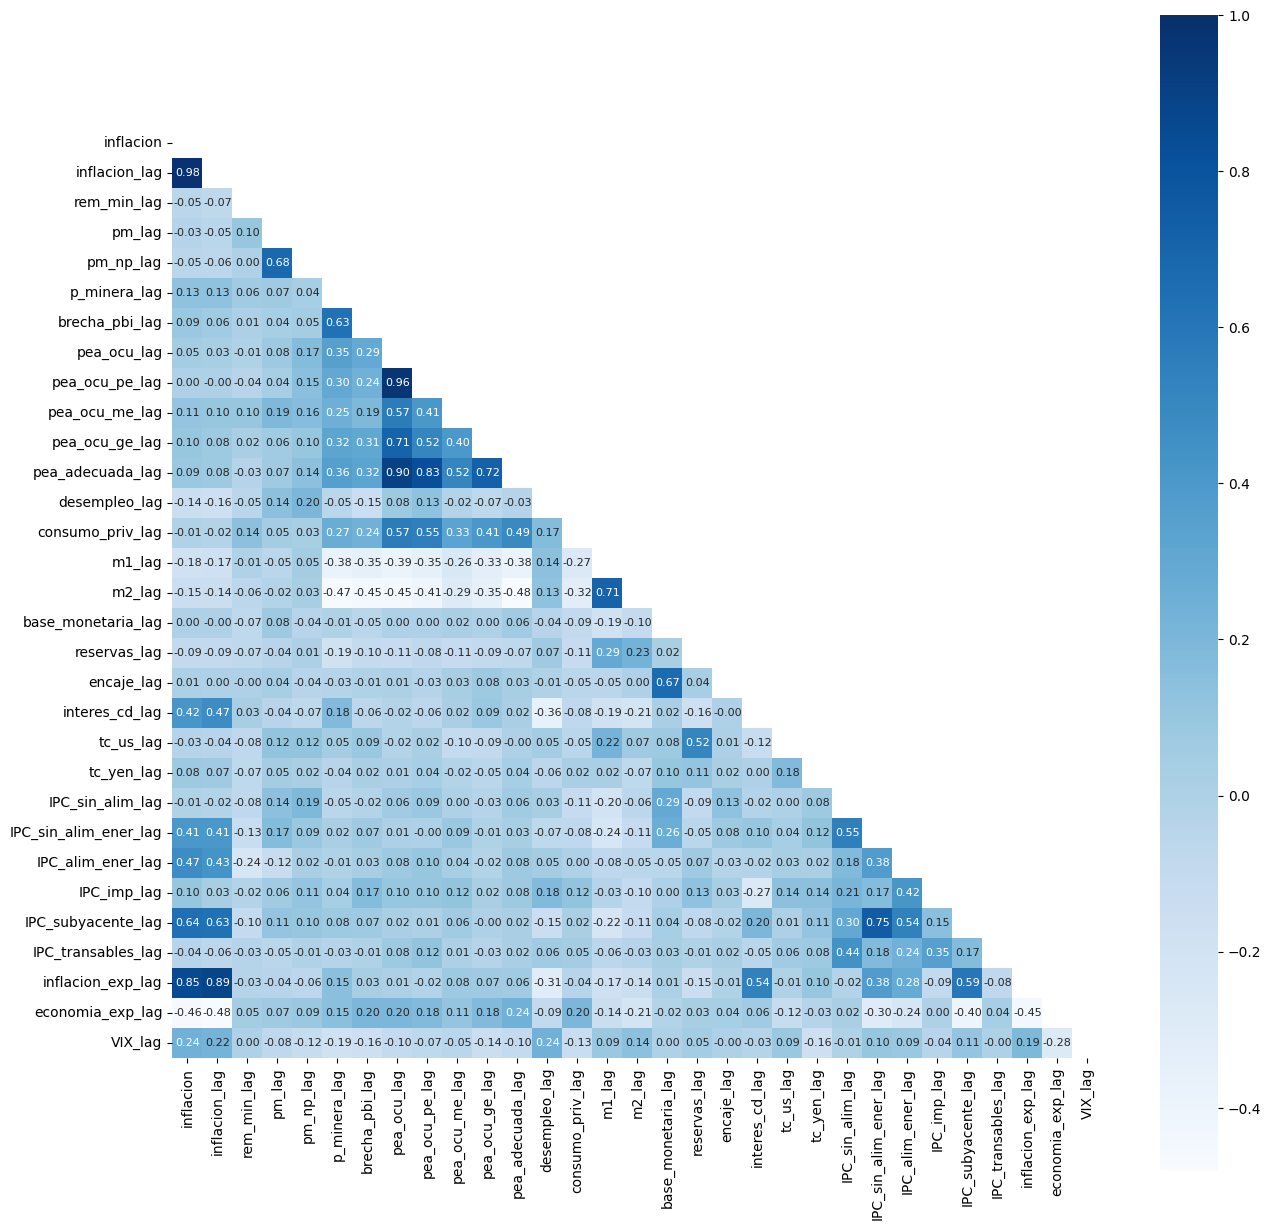

In [176]:
scale = StandardScaler()
df_scaled = pd.DataFrame(scale.fit_transform(df_noindex), columns=df_noindex.columns)

# Correlation matrix
corrmat = round(df_scaled.corr(),2)
mask = np.triu(np.ones_like(corrmat,dtype=bool))
f, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corrmat, vmax=1, square=True, annot=True, mask=mask, cmap='Blues', fmt=".2f", annot_kws={"size": 8})

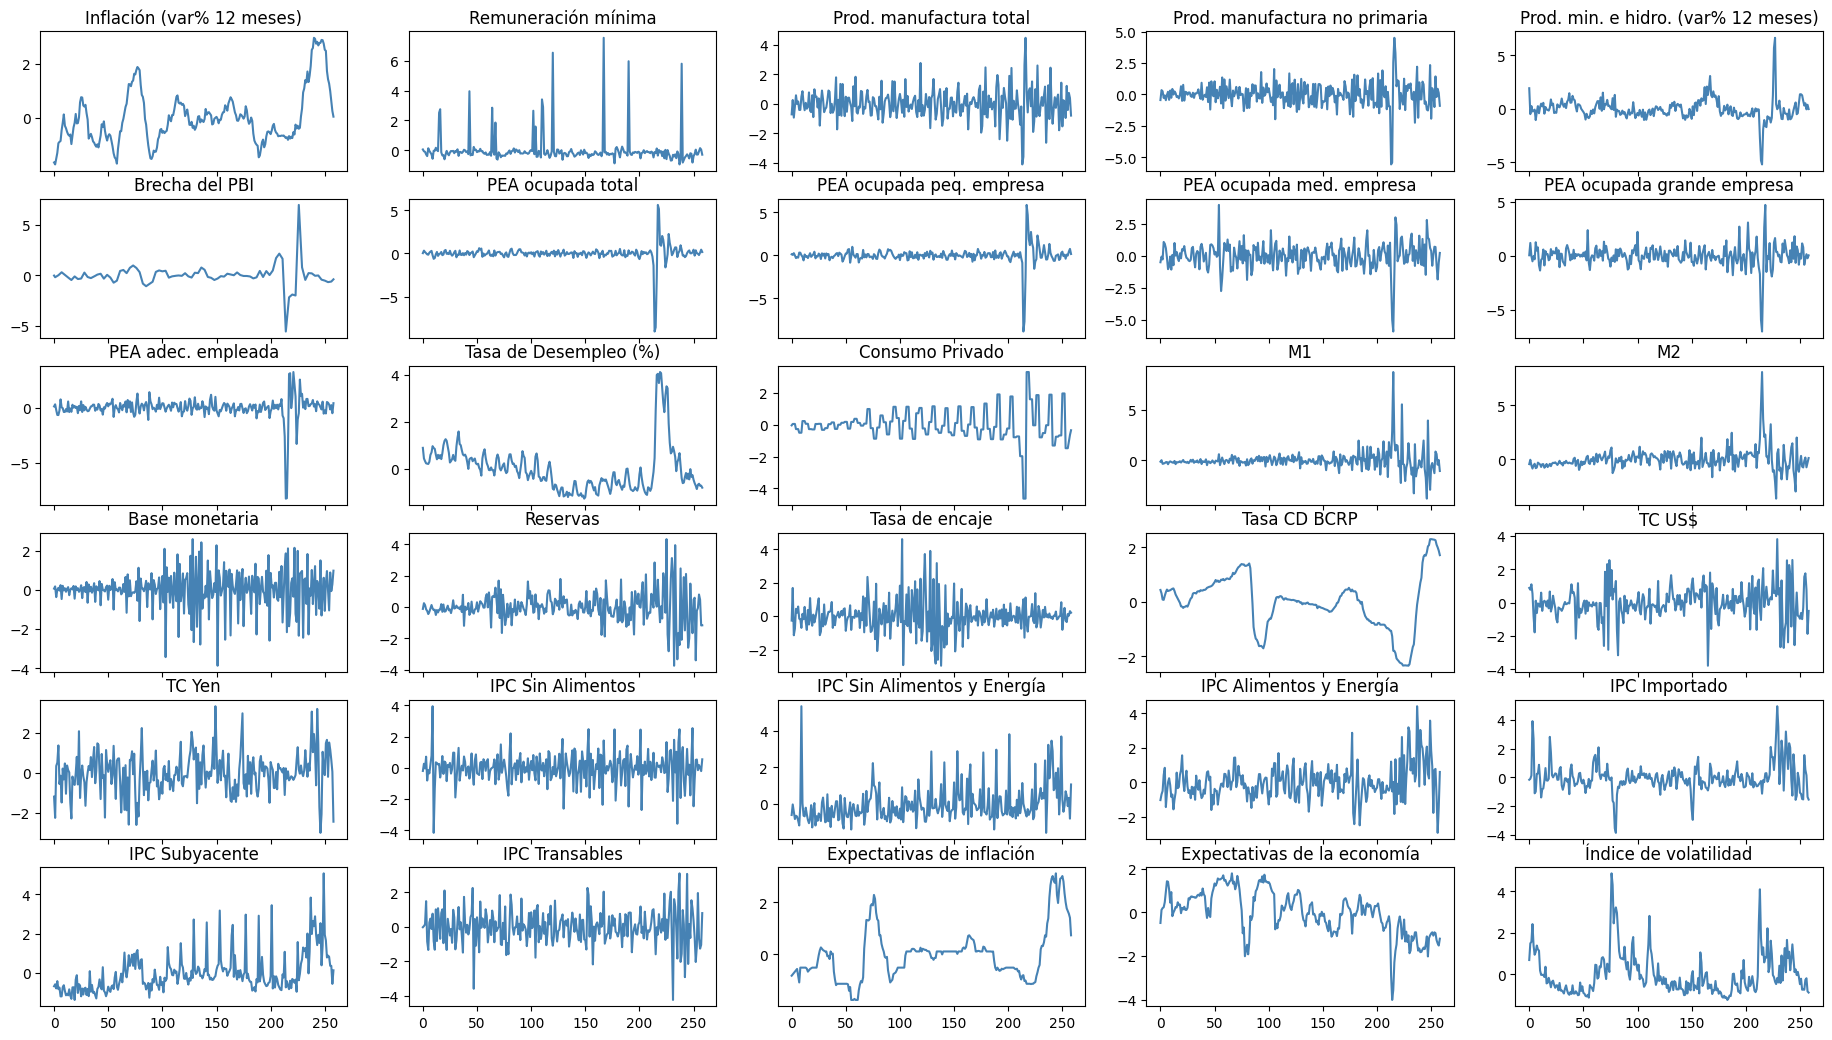

In [178]:
# Graph of parameters
df_scaled.iloc[:, 1:].plot(kind ='line',
            subplots = True,
            figsize = (23,17),
            title = ['Inflación (var% 12 meses)', 'Remuneración mínima', 'Prod. manufactura total', 'Prod. manufactura no primaria', 'Prod. min. e hidro. (var% 12 meses)',
                     'Brecha del PBI', 'PEA ocupada total', 'PEA ocupada peq. empresa', 'PEA ocupada med. empresa', 'PEA ocupada grande empresa', 
                     'PEA adec. empleada', 'Tasa de Desempleo (%)', 'Consumo Privado', 'M1', 'M2', 
                     'Base monetaria', 'Reservas', 'Tasa de encaje', 'Tasa CD BCRP', 'TC US$', 
                     'TC Yen', 'IPC Sin Alimentos', 'IPC Sin Alimentos y Energía', 'IPC Alimentos y Energía', 'IPC Importado', 
                     'IPC Subyacente', 'IPC Transables', 'Expectativas de inflación', 'Expectativas de la economía', 'Índice de volatilidad'],
            legend = False,
            layout = (8,5),
            sharex = True,
            color = 'steelblue')
plt.show()

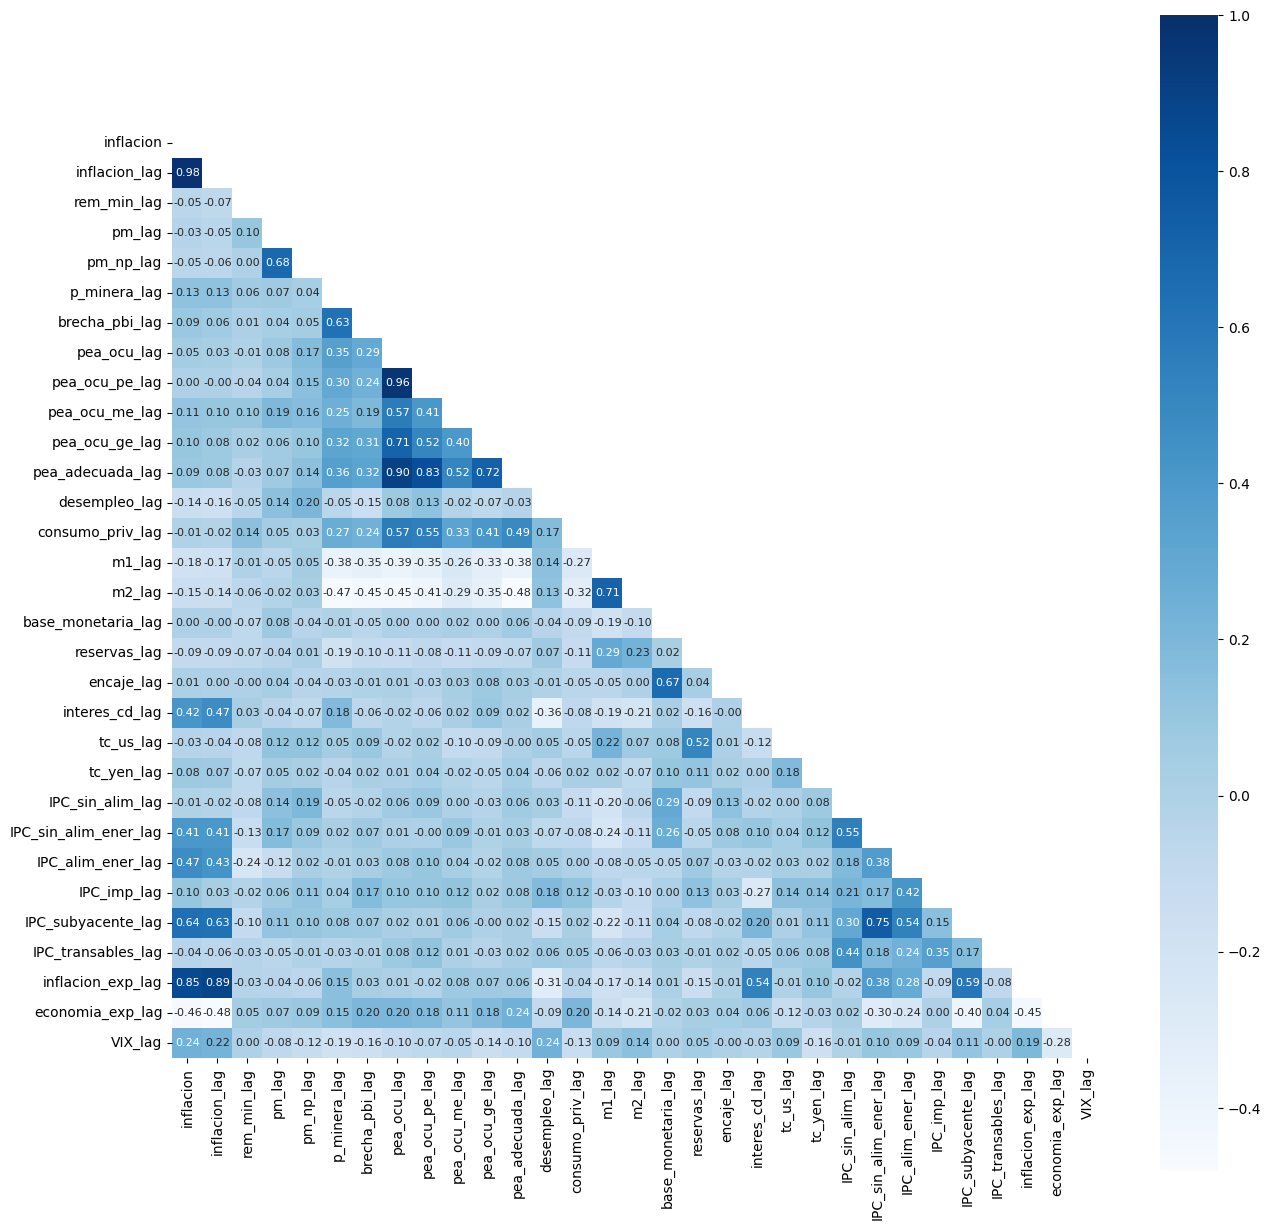

In [179]:
# Correlation matrix
corrmat = round(df_scaled.corr(),2)
mask = np.triu(np.ones_like(corrmat,dtype=bool))
f, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corrmat, vmax=1, square=True, annot=True, mask=mask, cmap='Blues', fmt=".2f", annot_kws={"size": 8})